## Perceptron learning

In the first part of this exercise we will reproduce the Figures in Chapter 39 of the MacKay book.

$x$ is an $p \times N$ matrix containing all the N-dimensional input vectors for each of the p patterns. We set $N=2$ and use an explicit threshold b in the perceptron activation; w[0] and w[1] are the weights.

$z$ is a vector of length p containing the targets for each training pattern, each target $\in$ {0,1}. In class we used the notation: $z^\mu$ and $x^\mu_i$.

We can choose two options: linearly separable patterns, or nonseparable patterns

In [1]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)

## Generate training set

In [2]:
def generate_patterns(spread,N=2,p1=100,p2=100,option='separable',plot=False):
    # spread parameter is the standard deviation of the the patterns around each center of the gaussian distribution
    # generate targets
    
    z=np.ones((p1+p2))# targets
    z[p1:]=0 # t2=0 targets
    x=np.zeros((p1+p2,N))
    
    # generate inputs
    if option=='separable':
        # separable targets
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
    elif option=='nonseparable':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]
    elif option=='weird':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]+1.5
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]+1
        z=np.ones((p1+p2))# targets
        z[0:int(p1/2)]=0; z[p1:int(p1+p2/2)]=0

    # make a figure
    if plot == True:
        fig,ax=plt.subplots()
        plt.title('Linearly {} Patterns with Spread of {}'.format(option,spread))
        size=100
        # scatterplot
        ax.scatter(x[z==1,0],x[z==1,1],s=size,color='red',alpha=0.25,label='+1')
        ax.scatter(x[z==0,0],x[z==0,1],s=size,color='blue',alpha=0.25,label='0')
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax.legend(loc='lower right')
        ax.axis('equal')  
    return x,z


(1000, 2)
(1000,)


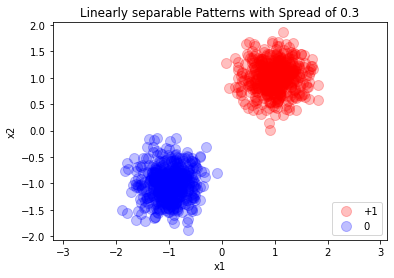

In [9]:
p1=500 # size of class 0
p2=500 # size of class 1
N=2 # dimension of input space
spread=0.3 # within-class spread of data
# training set
x,z=generate_patterns(spread=spread,N=N,p1=p1,p2=p2,option='separable',plot=True)
print(np.shape(x))
print(np.shape(z))

## Activity rule and cost function

Activation
$$
h^\mu=\sum_{i=1}^Nw_i x_i^\mu+b
$$

Activity: 
$$
f(h)={1\over 1+e^{-h}}
$$

Log-likelihood function: 
$$
G(z^\mu|x^\mu_i,w_i)=-\sum_{\mu=1}^p\left[z^\mu\ln f(h^\mu)+(1-z^\mu)\ln(1- f(h^\mu))\right]\ , \,\,h^\mu=\sum_{i=1}^Nw_ix_i^\mu+b
$$

Log-posterior: 
$$
M(w_i|z^\mu,x^\mu_i)=G(z^\mu|x^\mu_i,w_i)+{1\over2}\alpha \sum_{i=1}^Nw_i^2
$$

In [11]:
# activity rule
b=-1; # threshold (we called it w0 in class)
def sigmoid(h0,b,derivative=False):
    # h0=sum_i w_i x_i
    h=h0+b # activation
    out=1/(1+np.exp(-h))
    return out*(1-out) if derivative else out

def Gfunc(ww,xx,zz):
    # relative entropy between target labels and input patterns
    hh0=xx.dot(ww) # xx has dim (p,N) and ww has dim (N,) --> hh0 is a row vector of dim p
    ff=sigmoid(hh0,b)
    infhh=~np.isinf(np.log(ff))
    infhhm=~np.isinf(np.log(1-ff))
    out=-zz[infhh].dot(np.log(ff[infhh]))-(1-zz[infhhm]).dot(np.log(1-ff[infhhm]))
    return out

## Batch training using the perceptron learning rule
$$
w_i^{new}=w_i^{old}+\Delta w_i
$$

$$
\Delta w_i=\eta\sum_{\mu=1}^p\left[\left(z^\mu-f(h^\mu)\right]x_i^\mu-\alpha w_i\right)
$$

In [12]:
T=10000 # number of training steps
# snapshot of learning
stepPlot=T/1000

N=2
# initialize the weights
w0=(1/N**0.5)*np.random.randn(N)
print('initial weights %s' % w0)

# learning rate
eta=0.0001
# weight decay
alpha=0.

# training 
Gplot=[]; Mplot=[]; wplot=[]; yplot=[]; errorTrain=[];errorTest=[]
for step in range(T):
          if step==0: w=w0
          h=x.dot(w) # vector of dim p=p1+p2
          f=sigmoid(h,b) # vector of dim p
          err=z-f # vector of dim p
          gr=-err.dot(x) # vector of dim N
          w=w-eta*(gr+alpha*w)
          if step % stepPlot==0:
                  gtemp=Gfunc(w,x,z)
                  Gplot.append(gtemp) # store the log-likelihood
                  Mplot.append(gtemp+0.5*alpha*w.dot(w)) # store the log-posterior
                  wplot.append(w)
                  yplot.append(f)
                  errorfracTrain=sum(abs(np.round(f-z)))/len(z) # fraction of training patterns that have been misclassified
                  errorTrain.append(errorfracTrain)

          if step % (stepPlot*10)==0:
                print('{a1} steps, G: {a2:.6e}, M: {a5:.6e}, errorTrain: {a6}, weights: {a3:.4},{a4:.4}'.format(a1=step+1,a2=gtemp,a3=w[0],a4=w[1],a5=gtemp+0.5*alpha*w.dot(w),a6=errorfracTrain))

# fraction of misclassified input patterns at the end of training
print('fraction misclassified (Train): %s' % errorfracTrain)
# print('fraction misclassified (Test): %s' % errorfracTest)

initial weights [ 0.83887668 -1.23091431]
1 steps, G: 9.850729e+02, M: 9.850729e+02, errorTrain: 0.539, weights: 0.895,-1.171
101 steps, G: 7.797245e+01, M: 7.797245e+01, errorTrain: 0.001, weights: 2.529,0.6896
201 steps, G: 3.937621e+01, M: 3.937621e+01, errorTrain: 0.0, weights: 2.917,1.16
301 steps, G: 2.664478e+01, M: 2.664478e+01, errorTrain: 0.0, weights: 3.141,1.435
401 steps, G: 2.028063e+01, M: 2.028063e+01, errorTrain: 0.0, weights: 3.299,1.631
501 steps, G: 1.644742e+01, M: 1.644742e+01, errorTrain: 0.0, weights: 3.422,1.783
601 steps, G: 1.387796e+01, M: 1.387796e+01, errorTrain: 0.0, weights: 3.522,1.908
701 steps, G: 1.203144e+01, M: 1.203144e+01, errorTrain: 0.0, weights: 3.607,2.014
801 steps, G: 1.063789e+01, M: 1.063789e+01, errorTrain: 0.0, weights: 3.681,2.106
901 steps, G: 9.547259e+00, M: 9.547259e+00, errorTrain: 0.0, weights: 3.746,2.187
1001 steps, G: 8.669444e+00, M: 8.669444e+00, errorTrain: 0.0, weights: 3.805,2.26
1101 steps, G: 7.946990e+00, M: 7.946990e+


## Plot learning schedule

Plot classification probability $P=0.25,0.75$ using the activity rule (P is the output of the perceptron): $h=\log[P/(1-P)]$

<ipython-input-45-5fe36aa656ed>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xplot=stepPlot*(np.arange(np.int(T/stepPlot))+1)


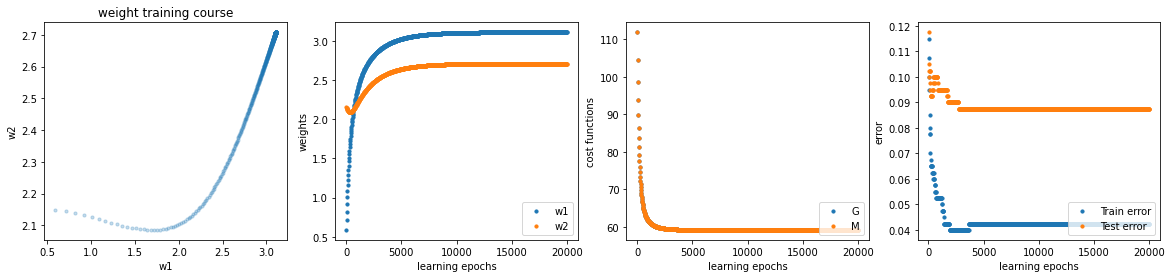

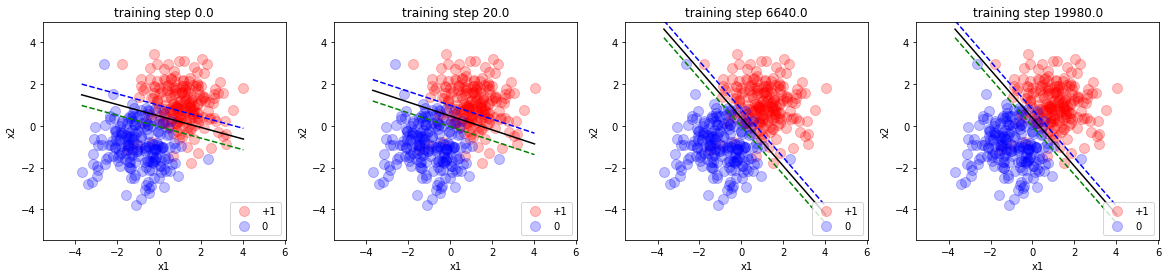

In [45]:
# plot evolution of the weights
fig,ax=plt.subplots(1,4,figsize=(20,4))
wplot1=np.array(wplot)
xplot=stepPlot*(np.arange(np.int(T/stepPlot))+1)
ax[0].scatter(wplot1[:,0],wplot1[:,1],s=10,alpha=0.25)
ax[0].set_xlabel('w1'); ax[0].set_ylabel('w2'); ax[0].set_title('weight training course')
for i in range(N):
    ax[1].scatter(xplot,wplot1[:,i],s=10,label='w%s' % (i+1))
    ax[1].legend(loc='lower right'); ax[1].set_xlabel('learning epochs'); ax[1].set_ylabel('weights'); #ax[1].set_xscale('log'
# plot cost functions
ax[2].scatter(xplot,np.array(Gplot),s=10,label='G')
ax[2].scatter(xplot,np.array(Mplot),s=10,label='M')
ax[2].legend(loc='lower right'); ax[2].set_xlabel('learning epochs'); ax[2].set_ylabel('cost functions'); #ax[1].set_xscale('log')
# plot error rate on the training set
ax[3].scatter(xplot,np.array(errorTrain),s=10,label='Train error')
ax[3].scatter(xplot,np.array(errorTest),s=10,label='Test error')
ax[3].legend(loc='lower right'); ax[3].set_xlabel('learning epochs'); ax[3].set_ylabel('error'); #ax[1].set_xscale('log')
# plt.savefig('figs/CLASS0_WeightTraining_Alpha' + '{}.pdf'.format(alpha), bbox_inches='tight')

# plot evolution of the classification boundary
fig,ax=plt.subplots(1,4,figsize=(20,4))
step=[0,1,int(np.round(wplot1.shape[0]/3))-1,int(np.round(wplot1.shape[0]))-1]
h25=np.log(0.25/(1-0.25)) # activation corresponding to 0.25 probability of t=1
h75=np.log(0.75/(1-0.75))# activation corresponding to 0.75 probability of t=1

for i in range(len(step)):
    size=100
    ax[i].scatter(x[z==1,0],x[z==1,1],s=size,color='red',alpha=0.25,label='+1')
    ax[i].scatter(x[z==0,0],x[z==0,1],s=size,color='blue',alpha=0.25,label='0')
    ax[i].set_xlabel("x1"); ax[i].set_ylabel("x2")
    ax[i].legend(loc='lower right')
    ax[i].axis('equal')
    x1=np.linspace(x[:,0].min(),x[:,0].max(),num=100)
    y0=(-b-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=0 activation
    y1=(-b-h25-wplot1[step[i],0]*x1)/wplot1[step[i],1]    # h=+1 activation
    ym1=(-b-h75-wplot1[step[i],0]*x1)/wplot1[step[i],1]   #h=-1 activation
    ax[i].plot(x1,y0,'k'); ax[i].plot(x1,y1,'--b'); ax[i].plot(x1,ym1,'--g');
    ax[i].set_title("training step %s" % (step[i]*stepPlot))
    ax[i].set_xlim(1.5*x1[0],1.5*x1[-1]); ax[i].set_ylim(1.5*x[:,1].min(),1.5*x[:,1].max());


## Learning as inference

In the second part of this exercise we will reproduce the Figures in Chapter 41 of the MacKay book.

Plot the log-likelihood $G(z^\mu|w_i|,x^\mu_i)$ and the log-posterior $M(w_i|z^\mu,x^\mu_i)$ as functions of the weights, for fixed training data $(z^\mu,x^\mu_i)$

In [20]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter, LogLocator

# size of the training set

# create a 2d grid of (w1,w2)
# log-likelihood
# log-posterior
# log-prior


# MAP estimate of the weights



/Users/mazzu/opt/anaconda2/envs/MATH607/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


w_MAP: w1=%s, w2=%s (array([1.5]), array([1.8]))


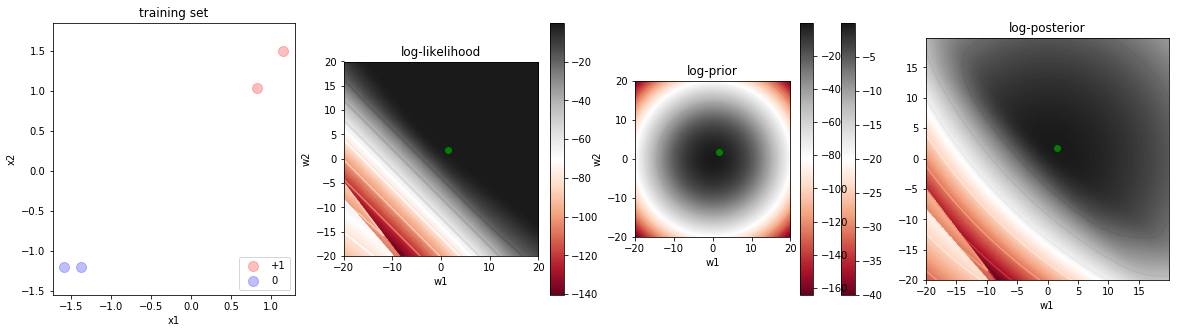

In [21]:
#=========
# PLOTS
#=========
# plot the surface
fig,ax=plt.subplots(1,4,figsize=(20,5))

# training set
size=100
# scatterplot
ax[0].scatter(xplot[0:ntrain,0],xplot[0:ntrain,1],s=size,color='red',alpha=0.25,label='+1')
ax[0].scatter(xplot[ntrain:2*ntrain,0],xplot[ntrain:2*ntrain,1],s=size,color='blue',alpha=0.25,label='0')
ax[0].set_xlabel("x1"); ax[0].set_ylabel("x2"); ax[0].set_title("training set")
ax[0].legend(loc='lower right')
ax[0].axis('equal')

# plot log-likelihood
surf1=ax[1].imshow(LLplot,origin='lower',cmap='RdGy',extent=[np.min(W1),np.max(W1),np.min(W2),np.max(W2)])
ax[1].contour(W1,W2,LLplot,cmap='RdGy')
fig.colorbar(surf1,ax=ax[1])
ax[1].set_title('log-likelihood'); ax[1].set_xlabel('w1'); ax[1].set_ylabel('w2')
ax[1].scatter(W1[wmapind],W2[wmapind],color='g')

# plot log-prior
surf3=ax[2].imshow(Priorplot,origin='lower',cmap='RdGy',extent=[np.min(W1),np.max(W1),np.min(W2),np.max(W2)])
ax[2].contour(W1,W2,Priorplot,cmap='RdGy')
fig.colorbar(surf3,ax=ax[2])
ax[2].set_title('log-prior'); ax[2].set_xlabel('w1'); ax[2].set_ylabel('w2')
ax[2].scatter(W1[wmapind],W2[wmapind],color='g')

# plot log-posterior
surf2=ax[3].imshow(Mplot,origin='lower',cmap='RdGy',extent=[np.min(W1),np.max(W1),np.min(W2),np.max(W2)])
ax[3].contour(W1,W2,Mplot,cmap='RdGy')
fig.colorbar(surf2,ax=ax[2])
ax[3].set_title('log-posterior'); ax[3].set_xlabel('w1'); ax[2].set_ylabel('w2')
ax[3].scatter(W1[wmapind],W2[wmapind],color='g')